In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score as sklearn_f1
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.base import clone
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)

In [51]:
train = pd.read_csv('data/train_c.csv')
test = pd.read_csv('data/test_c.csv')

print(f"Train: {train.shape}, Test: {test.shape}")
print(train.info())

Train: (11017, 35), Test: (5000, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64

Распределение классов:
LoanApproved
1.0    5367
0.0    5120
Name: count, dtype: int64
Пропорции классов:
LoanApproved
1.0    0.511776
0.0    0.488224
Name: proportion, dtype: float64


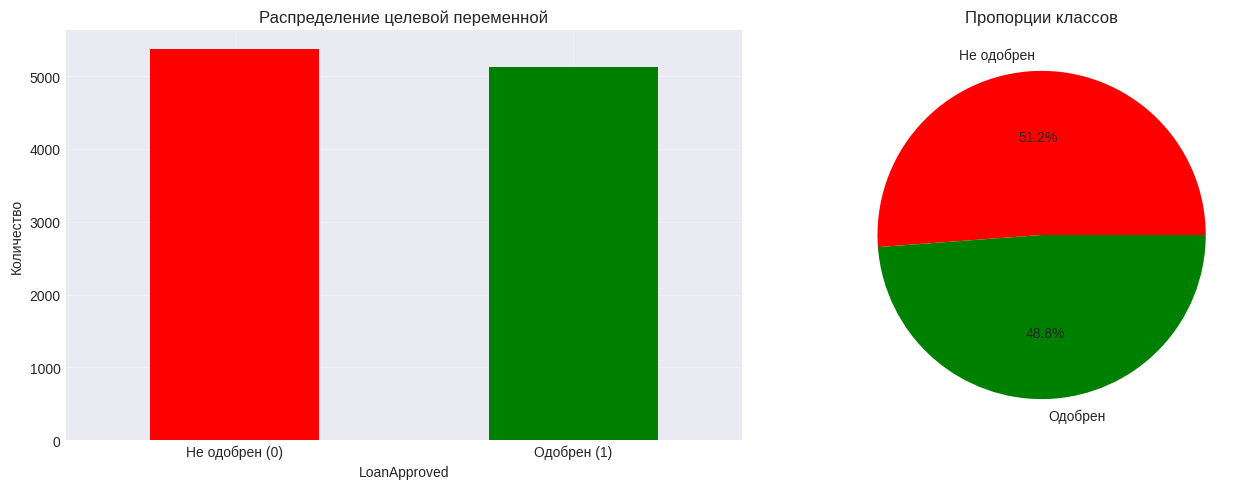

In [52]:
# Анализ целевой переменной LoanApproved
print(f"Распределение классов:")
print(train['LoanApproved'].value_counts())
print(f"Пропорции классов:")
print(train['LoanApproved'].value_counts(normalize=True))

# Визуализация целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Countplot
train['LoanApproved'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_xlabel('LoanApproved')
axes[0].set_ylabel('Количество')
axes[0].set_title('Распределение целевой переменной')
axes[0].set_xticklabels(['Не одобрен (0)', 'Одобрен (1)'], rotation=0)
axes[0].grid(True, alpha=0.3)

# Pie chart
train['LoanApproved'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                          colors=['red', 'green'], labels=['Не одобрен', 'Одобрен'])
axes[1].set_ylabel('')
axes[1].set_title('Пропорции классов')

plt.tight_layout()
plt.show()

In [53]:
# Анализ числовых признаков
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'LoanApproved' in numeric_cols:
    numeric_cols.remove('LoanApproved')
if 'ID' in numeric_cols:
    numeric_cols.remove('ID')

print(f"Числовых признаков: {len(numeric_cols)}")
print(f"Статистика числовых признаков:")
print(train[numeric_cols].describe())

# Корреляция с целевой переменной
correlations = train[numeric_cols + ['LoanApproved']].corr()['LoanApproved'].drop('LoanApproved').sort_values(ascending=False)

print(f"\nТоп-15 корреляций с LoanApproved:")
print(correlations.head(15))

Числовых признаков: 28
Статистика числовых признаков:
                Age   AnnualIncome  CreditScore     LoanAmount  LoanDuration  \
count  10487.000000   10487.000000  9986.000000    9986.000000  10487.000000   
mean      39.850386  131587.872127   678.082716   29874.218306     53.439878   
std       11.614132  115791.941909   175.192486   27705.509722     24.493562   
min       18.000000   15000.000000   300.000000    1063.000000     12.000000   
25%       32.000000   20959.500000   550.000000   12658.000000     36.000000   
50%       40.000000   89015.000000   722.500000   21828.500000     48.000000   
75%       48.000000  257025.000000   850.000000   37158.000000     60.000000   
max       80.000000  748508.000000   850.000000  418997.000000    120.000000   

       NumberOfDependents  MonthlyDebtPayments  CreditCardUtilizationRate  \
count        10487.000000          9986.000000               10487.000000   
mean             1.568323           546.458642                   0.2843

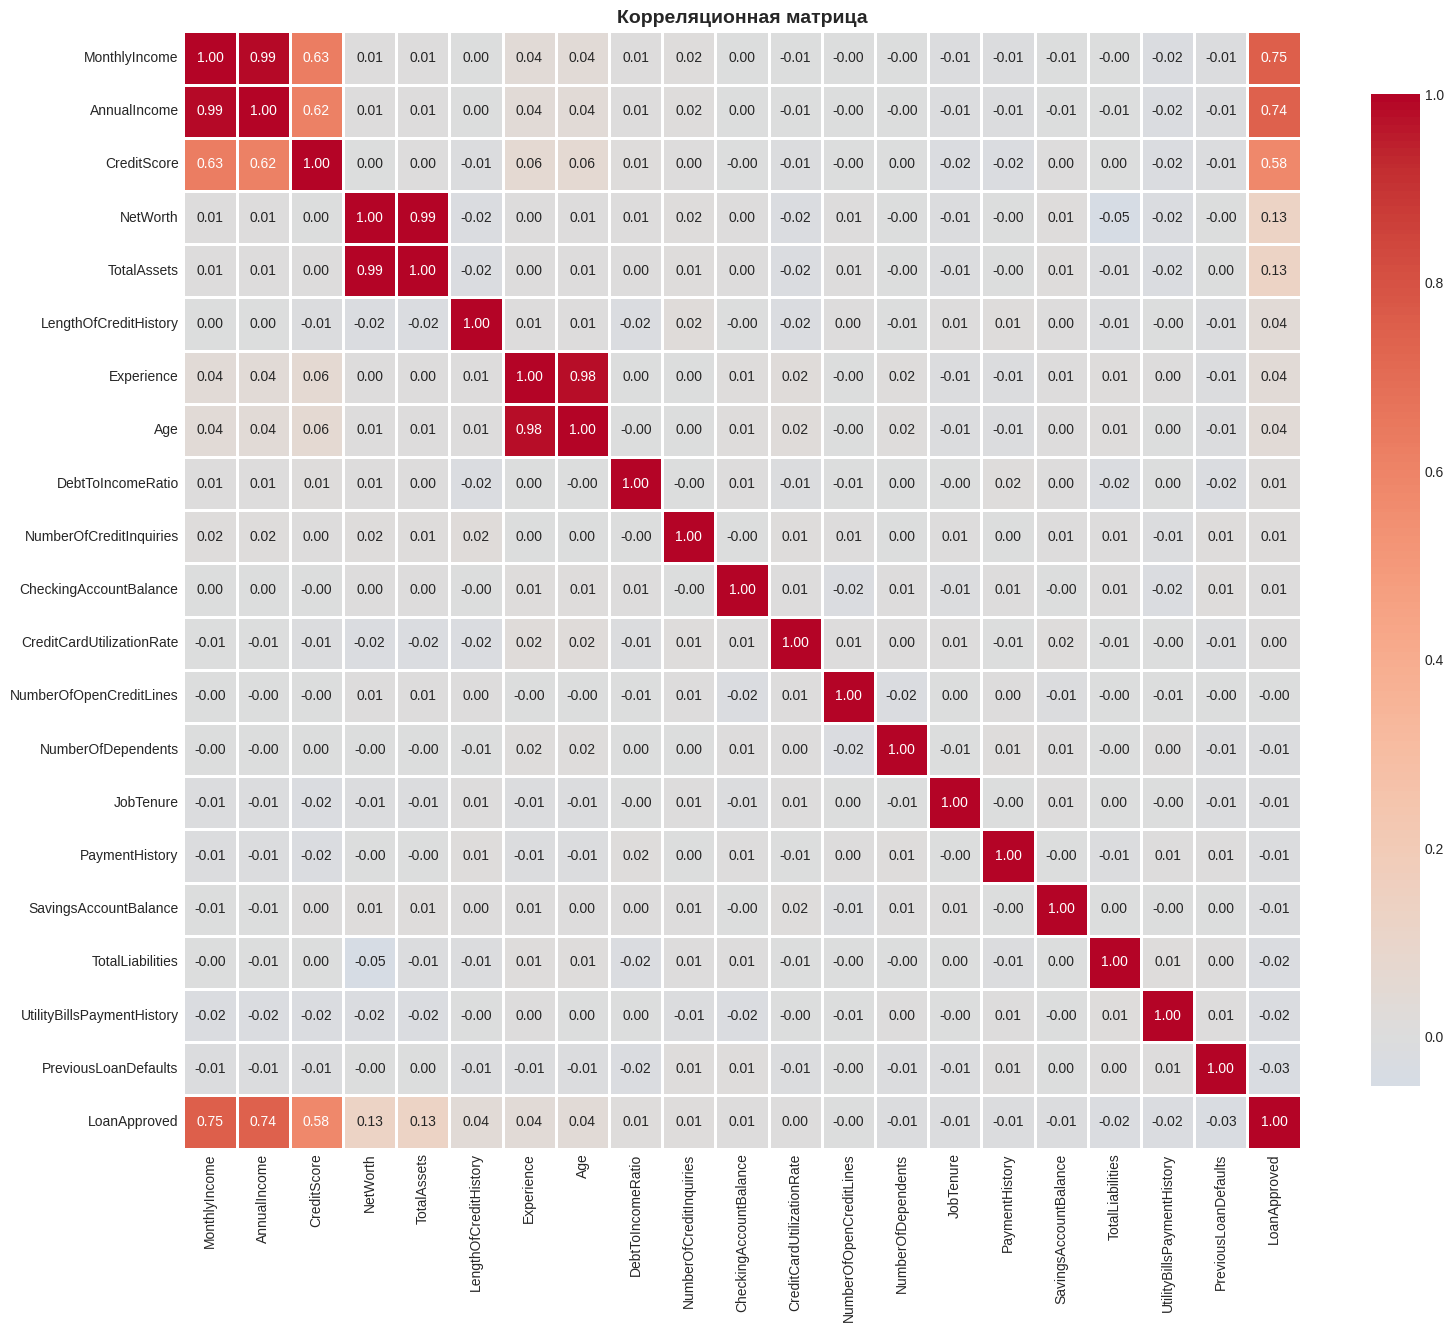

In [54]:
# Корреляционная матрица
top_features = correlations.abs().head(20).index.tolist()
corr_matrix = train[top_features + ['LoanApproved']].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

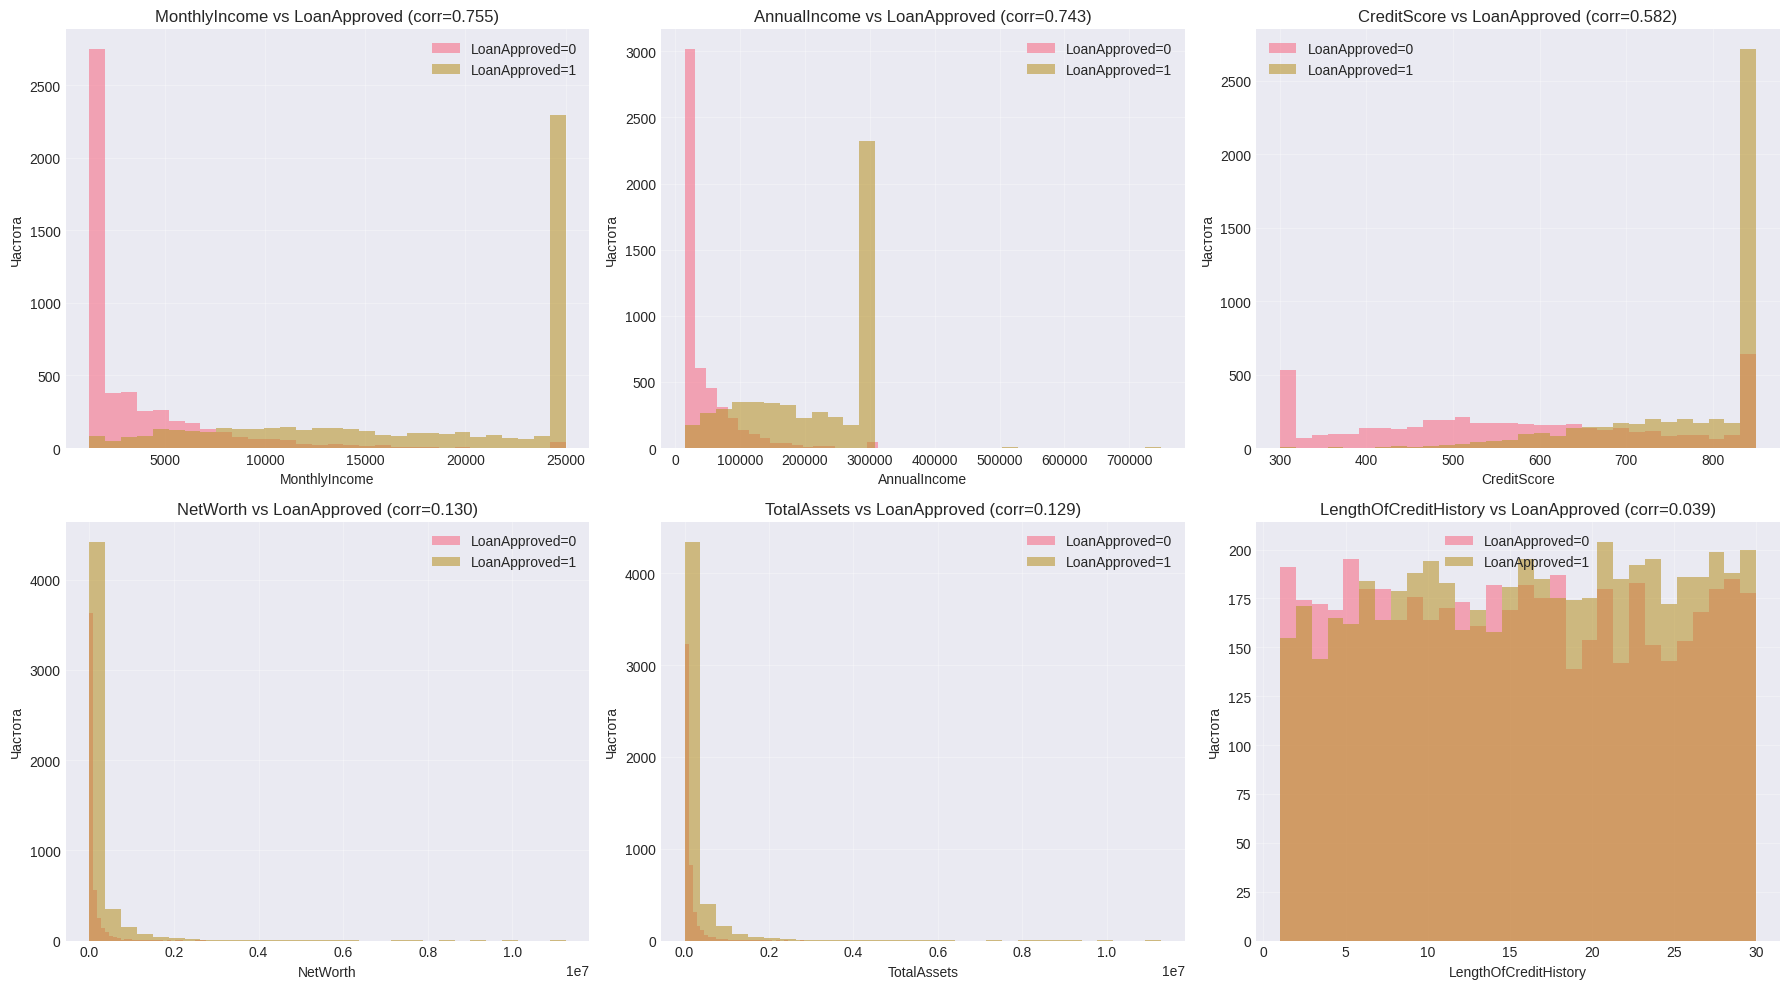

In [ ]:
# Графики зависимостей признаков от целевой переменной. Первые 6
top_6_features = correlations.abs().head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    for loan_status in [0, 1]:
        data = train[train['LoanApproved'] == loan_status][feature]
        axes[idx].hist(data, alpha=0.6, bins=30, label=f'LoanApproved={loan_status}')
    
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Частота')
    axes[idx].set_title(f'{feature} vs LoanApproved (corr={correlations[feature]:.3f})')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

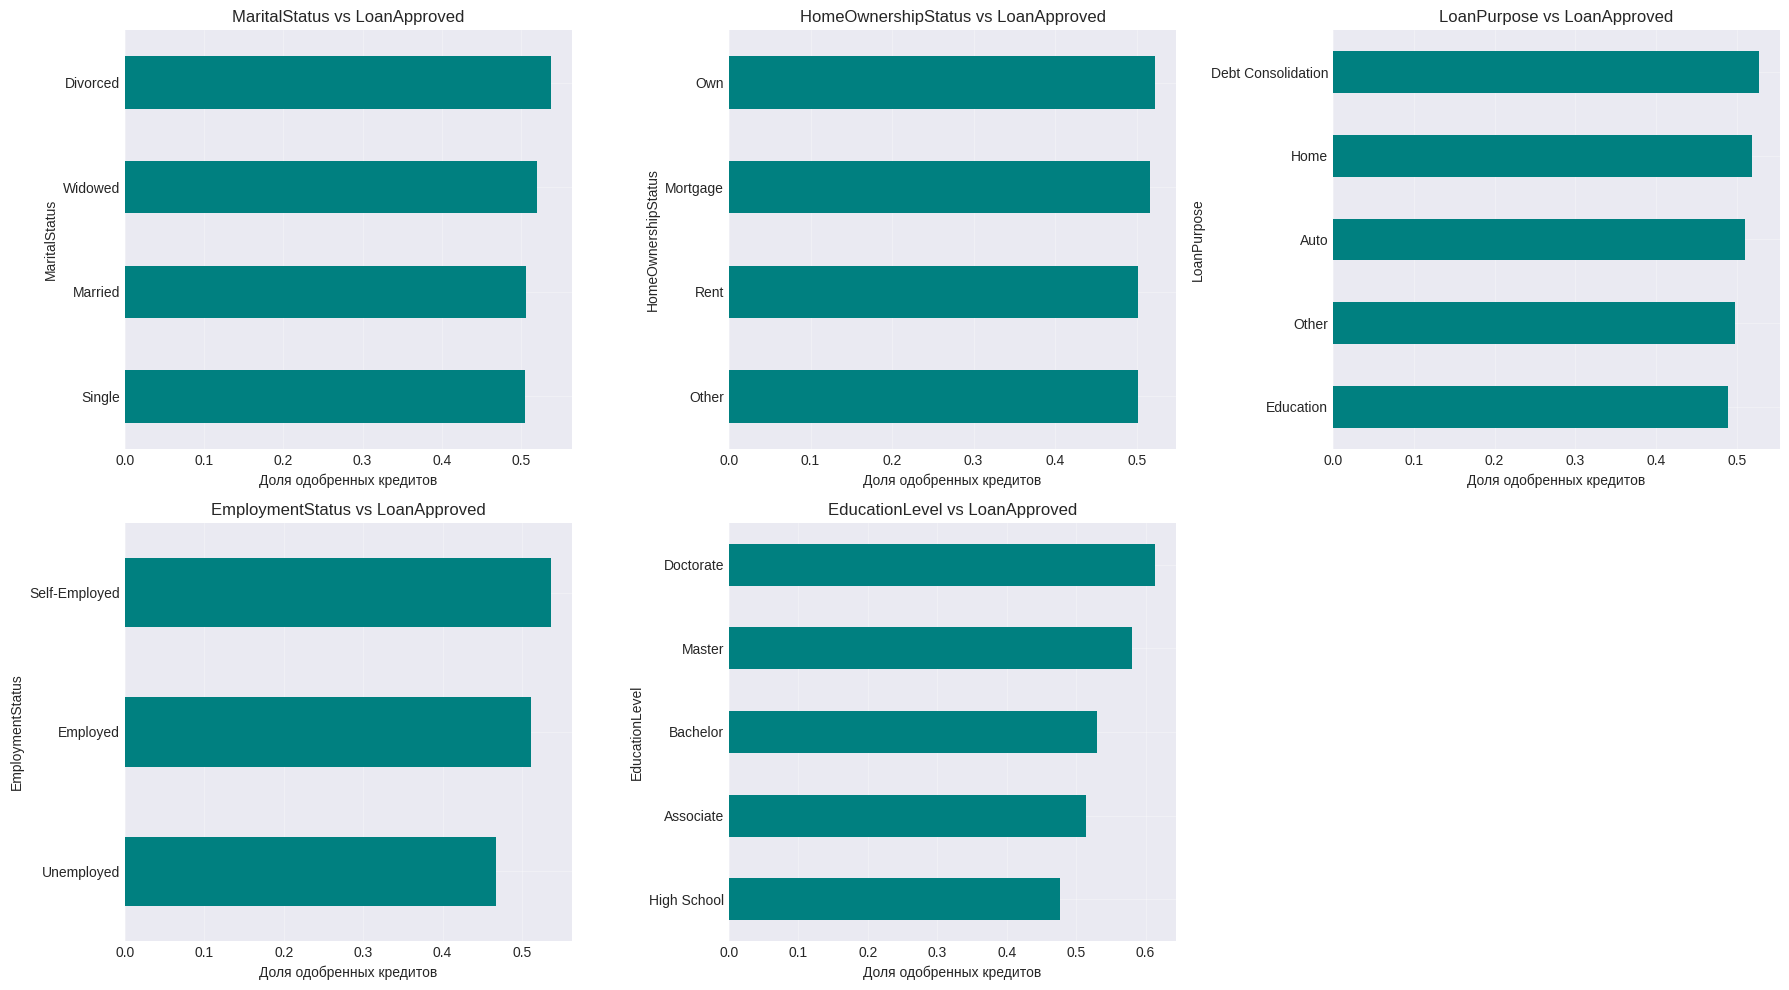

In [55]:
# Анализ категориальных признаков
categorical_cols = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 
                   'EmploymentStatus', 'EducationLevel']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    grouped = train.groupby(col)['LoanApproved'].mean().sort_values()
    grouped.plot(kind='barh', ax=axes[idx], color='teal')
    axes[idx].set_xlabel('Доля одобренных кредитов')
    axes[idx].set_title(f'{col} vs LoanApproved')
    axes[idx].grid(True, alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Подготовка данных для обучения
def prepare_data(train_df, test_df):
    """Подготовка данных"""
    df = train_df.copy()
    test_df_proc = test_df.copy()
    
    # Удаляем признаки с низкой информативностью
    drop_cols = ['ApplicationDate']
    
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    test_df_proc = test_df_proc.drop(columns=[c for c in drop_cols if c in test_df_proc.columns and c != 'ID'])
    
    # Удаляем строки с NaN в LoanApproved
    if 'LoanApproved' in df.columns:
        df = df.dropna(subset=['LoanApproved'])
    
    # Выделяем целевую переменную
    y = df['LoanApproved'].copy()
    X = df.drop(columns=['LoanApproved'])
    
    # Сохраняем ID для test
    test_ids = None
    if 'ID' in test_df_proc.columns:
        test_ids = test_df_proc['ID'].copy()
        test_df_proc = test_df_proc.drop(columns=['ID'])
    
    # Удаляем ID из train
    if 'ID' in X.columns:
        X = X.drop(columns=['ID'])
    
    # Кодируем категориальные признаки
    cat_cols = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 
                'EmploymentStatus', 'EducationLevel']
    
    for col in cat_cols:
        if col in X.columns:
            dummies_train = pd.get_dummies(X[col], prefix=col, drop_first=True)
            X = pd.concat([X.drop(columns=[col]), dummies_train], axis=1)
            
            if col in test_df_proc.columns:
                dummies_test = pd.get_dummies(test_df_proc[col], prefix=col, drop_first=True)
                test_df_proc = pd.concat([test_df_proc.drop(columns=[col]), dummies_test], axis=1)
                
                # Выравниваем колонки
                for c in dummies_train.columns:
                    if c not in dummies_test.columns:
                        test_df_proc[c] = 0
    
    # Выравниваем колонки train/test
    for col in X.columns:
        if col not in test_df_proc.columns:
            test_df_proc[col] = 0
    test_df_proc = test_df_proc[X.columns]
    
    # Обработка выбросов (clipping по квантилям)
    for col in X.select_dtypes(include=[np.number]).columns:
        q01 = X[col].quantile(0.01)
        q99 = X[col].quantile(0.99)
        X[col] = X[col].clip(lower=q01, upper=q99)
        test_df_proc[col] = test_df_proc[col].clip(lower=q01, upper=q99)
    
    # Заполнение пропусков медианой
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            median_val = X[col].median()
            X[col] = X[col].fillna(median_val)
            if col in test_df_proc.columns:
                test_df_proc[col] = test_df_proc[col].fillna(median_val)
    
    return X, y, test_df_proc, test_ids

X, y, X_test, test_ids = prepare_data(train, test)

In [ ]:
# Разделение на train/validation и масштабирование
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print(f"Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")
print(f"Распределение классов в train: {y_train.value_counts().to_dict()}")
print(f"Распределение классов в val: {y_val.value_counts().to_dict()}")

Train: (8389, 44), Val: (2098, 44), Test: (5000, 44)
Распределение классов в train: {1.0: 4293, 0.0: 4096}
Распределение классов в val: {1.0: 1074, 0.0: 1024}


## Блок 2: Метрики классификации - 2 балла (4×0.5p)

**Задачи:**
- Реализовать Accuracy + сравнение с sklearn
- Реализовать Precision + сравнение с sklearn
- Реализовать Recall + сравнение с sklearn
- Реализовать F1-score + сравнение с sklearn

In [59]:
# Реализация метрик классификации

def accuracy(y_true, y_pred):
    """
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    Доля правильных предсказаний
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(y_true == y_pred)


def precision(y_true, y_pred):
    """
    Precision = TP / (TP + FP)
    Доля правильных среди предсказанных положительных
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)


def recall(y_true, y_pred):
    """
    Recall (Sensitivity, TPR) = TP / (TP + FN)
    Доля найденных положительных среди всех положительных
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)


def f1_score(y_true, y_pred):
    """
    F1-score = 2 * (Precision * Recall) / (Precision + Recall)
    Гармоническое среднее Precision и Recall
    """
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    
    if prec + rec == 0:
        return 0.0
    return 2 * (prec * rec) / (prec + rec)

In [ ]:

# Создаем тестовые данные
y_true_test = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1])
y_pred_test = np.array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1])

print("тест метрик Custom sklearn")
print(f"y_true: {y_true_test}")
print(f"y_pred: {y_pred_test}")


# Accuracy
acc_custom = accuracy(y_true_test, y_pred_test)
acc_sklearn = accuracy_score(y_true_test, y_pred_test)
print(f"Accuracy:")
print(f"Custom:  {acc_custom:.6f}")
print(f"sklearn: {acc_sklearn:.6f}")
print(f"Разница: {abs(acc_custom - acc_sklearn)}")
print()

# Precision
prec_custom = precision(y_true_test, y_pred_test)
prec_sklearn = precision_score(y_true_test, y_pred_test)
print(f"Precision:")
print(f"Custom:  {prec_custom:.6f}")
print(f"sklearn: {prec_sklearn:.6f}")
print(f"Разница: {abs(prec_custom - prec_sklearn)}")
print()

# Recall
rec_custom = recall(y_true_test, y_pred_test)
rec_sklearn = recall_score(y_true_test, y_pred_test)
print(f"Recall:")
print(f"Custom:  {rec_custom:.6f}")
print(f"sklearn: {rec_sklearn:.6f}")
print(f"Разница: {abs(rec_custom - rec_sklearn)}")
print()

# F1-score
f1_custom = f1_score(y_true_test, y_pred_test)
f1_sklearn = sklearn_f1(y_true_test, y_pred_test)
print(f"F1-score:")
print(f"Custom:  {f1_custom:.6f}")
print(f"sklearn: {f1_sklearn:.6f}")
print(f"Разница: {abs(f1_custom - f1_sklearn)}")

тест метрик Custom sklearn
y_true: [1 0 1 1 0 1 0 0 1 1]
y_pred: [1 0 1 0 0 1 1 0 1 1]
Accuracy:
Custom:  0.800000
sklearn: 0.800000
Разница: 0.0

Precision:
Custom:  0.833333
sklearn: 0.833333
Разница: 0.0

Recall:
Custom:  0.833333
sklearn: 0.833333
Разница: 0.0

F1-score:
Custom:  0.833333
sklearn: 0.833333
Разница: 0.0


In [ ]:
# Обучаем простую модель для проверки метрик
lr_test = LogisticRegression(random_state=42, max_iter=1000)
lr_test.fit(X_train_scaled, y_train)
y_val_pred = lr_test.predict(X_val_scaled)

print("проверка метрик на реальных данных")
print()

# Сравнение всех метрик
metrics_comparison = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Custom': [
        accuracy(y_val, y_val_pred),
        precision(y_val, y_val_pred),
        recall(y_val, y_val_pred),
        f1_score(y_val, y_val_pred)
    ],
    'sklearn': [
        accuracy_score(y_val, y_val_pred),
        precision_score(y_val, y_val_pred),
        recall_score(y_val, y_val_pred),
        sklearn_f1(y_val, y_val_pred)
    ]
})

metrics_comparison['Разница'] = abs(metrics_comparison['Custom'] - metrics_comparison['sklearn'])

print(f"{metrics_comparison.to_string(index=False)}")

проверка метрик на реальных данных

  Метрика   Custom  sklearn  Разница
 Accuracy 0.926597 0.926597      0.0
Precision 0.930712 0.930712      0.0
   Recall 0.925512 0.925512      0.0
 F1-score 0.928105 0.928105      0.0


In [69]:
class CustomBagging:
    """
    Реализация Bagging (Bootstrap Aggregating)

    Параметры:
    base_estimator : объект классификатора (по умолчанию DecisionTreeClassifier)
    n_estimators : int, количество базовых моделей
    max_samples : float, доля объектов для каждого bootstrap-сэмпла (0 < max_samples <= 1.0)
    random_state : int, для воспроизводимости
    """
    
    def __init__(self, base_estimator=None, n_estimators=10, max_samples=1.0, random_state=42):
        if base_estimator is None:
            self.base_estimator = DecisionTreeClassifier(random_state=random_state)
        else:
            self.base_estimator = base_estimator
        
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state
        self.estimators_ = []
        
    def fit(self, X, y):
        """
        Обучение ансамбля на bootstrap-выборках
        
        Параметры:
        X : array-like, shape (n_samples, n_features)
        y : array-like, shape (n_samples,)
        
        Returns:
        self
        """
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        bootstrap_size = int(n_samples * self.max_samples)
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            # Bootstrap sampling: случайная выборка с возвращением
            indices = np.random.choice(n_samples, size=bootstrap_size, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            
            estimator = clone(self.base_estimator)
            estimator.fit(X_bootstrap, y_bootstrap)
            self.estimators_.append(estimator)
        
        return self
    
    def predict(self, X):
        """
        Предсказание классов (мажоритарное голосование)
        
        Параметры:
        X : array-like, shape (n_samples, n_features)
        
        Returns:
        y_pred : array, shape (n_samples,)
        """
        # Получаем предсказания от всех моделей
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
        
        # Мажоритарное голосование
        y_pred = np.apply_along_axis(
            lambda x: np.bincount(x.astype(int)).argmax(),
            axis=0,
            arr=predictions
        )
        
        return y_pred
    
    def predict_proba(self, X):
        """
        Предсказание вероятностей классов (усреднение)
        
        Параметры:
        X : array-like, shape (n_samples, n_features)
        
        Returns:
        proba : array, shape (n_samples, n_classes)
        """
        # Получаем вероятности от всех моделей
        probas = np.array([estimator.predict_proba(X) for estimator in self.estimators_])
        
        # Усредняем вероятности
        avg_proba = np.mean(probas, axis=0)
        
        return avg_proba

In [71]:
custom_bagging = CustomBagging(
    base_estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    max_samples=0.8,
    random_state=42
)

custom_bagging.fit(X_train_scaled.values, y_train.values)

y_val_pred_custom = custom_bagging.predict(X_val_scaled.values)
y_val_proba_custom = custom_bagging.predict_proba(X_val_scaled.values)[:, 1]

acc_custom = accuracy(y_val, y_val_pred_custom)
prec_custom = precision(y_val, y_val_pred_custom)
rec_custom = recall(y_val, y_val_pred_custom)
f1_custom = f1_score(y_val, y_val_pred_custom)
roc_auc_custom = roc_auc_score(y_val, y_val_proba_custom)

print(f"Результаты CustomBagging на валидации:")
print()
print(f"Accuracy: {acc_custom}")
print(f"Precision: {prec_custom}")
print(f"Recall: {rec_custom}")
print(f"F1-Score: {f1_custom}")
print(f"ROC-AUC: {roc_auc_custom}")


Результаты CustomBagging на валидации:

Accuracy: 0.9122974261201144
Precision: 0.9105166051660517
Recall: 0.9189944134078212
F1-Score: 0.9147358665430956
ROC-AUC: 0.9753472525314246


In [ ]:
# Сравнение с sklearn BaggingClassifier
sklearn_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    max_samples=0.8,
    random_state=42
)

sklearn_bagging.fit(X_train_scaled.values, y_train.values)

# Предсказания
y_val_pred_sklearn = sklearn_bagging.predict(X_val_scaled.values)
y_val_proba_sklearn = sklearn_bagging.predict_proba(X_val_scaled.values)[:, 1]

# Метрики
acc_sklearn = accuracy(y_val.values, y_val_pred_sklearn)
prec_sklearn = precision(y_val.values, y_val_pred_sklearn)
rec_sklearn = recall(y_val.values, y_val_pred_sklearn)
f1_sklearn = f1_score(y_val.values, y_val_pred_sklearn)
roc_auc_sklearn = roc_auc_score(y_val.values, y_val_proba_sklearn)

print(f"Результаты sklearn BaggingClassifier на валидации:")
print()
print(f"Accuracy: {acc_sklearn}")
print(f"Precision: {prec_sklearn}")
print(f"Recall: {rec_sklearn}")
print(f"F1-Score: {f1_sklearn}")
print(f"ROC-AUC: {roc_auc_sklearn}")
print()

# Таблица сравнения
print("сравнение: CustomBagging vs sklearn BaggingClassifier")

comparison_df = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'CustomBagging': [acc_custom, prec_custom, rec_custom, f1_custom, roc_auc_custom],
    'sklearn Bagging': [acc_sklearn, prec_sklearn, rec_sklearn, f1_sklearn, roc_auc_sklearn],
    'Разница (abs)': [
        abs(acc_custom - acc_sklearn),
        abs(prec_custom - prec_sklearn),
        abs(rec_custom - rec_sklearn),
        abs(f1_custom - f1_sklearn),
        abs(roc_auc_custom - roc_auc_sklearn)
    ]
})

print(comparison_df.to_string(index=False))

Результаты sklearn BaggingClassifier на валидации:

Accuracy: 0.9146806482364156
Precision: 0.909423604757548
Recall: 0.925512104283054
F1-Score: 0.917397323488694
ROC-AUC: 0.9744257012337056

сравнение: CustomBagging vs sklearn BaggingClassifier
  Метрика  CustomBagging  sklearn Bagging  Разница (abs)
 Accuracy       0.912297         0.914681       0.002383
Precision       0.910517         0.909424       0.001093
   Recall       0.918994         0.925512       0.006518
 F1-Score       0.914736         0.917397       0.002661
  ROC-AUC       0.975347         0.974426       0.000922


In [75]:
class CustomGradientBoosting:
    """
    Реализация Gradient Boosting для бинарной классификации.
    
    Параметры:
    n_estimators : int, количество базовых моделей (деревьев)
    learning_rate : float, скорость обучения (shrinkage)
    max_depth : int, максимальная глубина деревьев
    random_state : int, для воспроизводимости
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees_ = []
        self.init_pred_ = None
        
    def _sigmoid(self, x):
        """Сигмоида для преобразования логитов в вероятности."""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def _log_odds(self, y):
        """Начальное предсказание (log-odds)."""
        pos = np.sum(y == 1)
        neg = np.sum(y == 0)
        return np.log(pos / neg)
    
    def fit(self, X, y):
        """
        Обучение градиентного бустинга.
        
        Параметры:
        X : array-like, shape (n_samples, n_features)
        y : array-like, shape (n_samples,)
        
        Returns:
        self
        """
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        
        # Начальное предсказание (log-odds)
        self.init_pred_ = self._log_odds(y)
        
        # Текущие предсказания (логиты)
        F = np.full(n_samples, self.init_pred_)
        
        self.trees_ = []
        
        for i in range(self.n_estimators):
            proba = self._sigmoid(F)
            
            # Градиент функции потерь (negative gradient для log-loss)
            # binary cross-entropy: gradient = y - p(y=1)
            residuals = y - proba
            
            # Обучаем дерево регрессии на остатках (градиентах)
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state + i
            )
            tree.fit(X, residuals)
            
            # Предсказания дерева
            tree_pred = tree.predict(X)
            
            # Обновляем F с учетом learning_rate
            F += self.learning_rate * tree_pred
            
            self.trees_.append(tree)
        
        return self
    
    def predict_proba(self, X):
        """
        Предсказание вероятностей классов.
        
        Параметры:
        X : array-like, shape (n_samples, n_features)
        
        Returns:
        proba : array, shape (n_samples, 2)
        """
        n_samples = X.shape[0]
        
        F = np.full(n_samples, self.init_pred_)
        
        # Суммируем предсказания всех деревьев
        for tree in self.trees_:
            F += self.learning_rate * tree.predict(X)
        
        # Преобразуем в вероятности
        proba_pos = self._sigmoid(F)
        proba_neg = 1 - proba_pos
        
        return np.column_stack([proba_neg, proba_pos])
    
    def predict(self, X):
        """
        Предсказание классов.
        
        Параметры:
        X : array-like, shape (n_samples, n_features)
        
        Returns:
        y_pred : array, shape (n_samples,)
        """
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)

In [76]:
# Обучение CustomGradientBoosting
custom_gb = CustomGradientBoosting(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

custom_gb.fit(X_train_scaled.values, y_train.values)

# Предсказания
y_val_pred_custom_gb = custom_gb.predict(X_val_scaled.values)
y_val_proba_custom_gb = custom_gb.predict_proba(X_val_scaled.values)[:, 1]

# Метрики
acc_custom_gb = accuracy(y_val.values, y_val_pred_custom_gb)
prec_custom_gb = precision(y_val.values, y_val_pred_custom_gb)
rec_custom_gb = recall(y_val.values, y_val_pred_custom_gb)
f1_custom_gb = f1_score(y_val.values, y_val_pred_custom_gb)
roc_auc_custom_gb = roc_auc_score(y_val.values, y_val_proba_custom_gb)

print(f"Результаты CustomGradientBoosting на валидации:")
print()
print(f"Accuracy: {acc_custom_gb}")
print(f"Precision: {prec_custom_gb}")
print(f"Recall: {rec_custom_gb}")
print(f"F1-Score: {f1_custom_gb}")
print(f"ROC-AUC: {roc_auc_custom_gb}")

Результаты CustomGradientBoosting на валидации:

Accuracy: 0.9161105815061964
Precision: 0.9157407407407407
Recall: 0.9208566108007449
F1-Score: 0.9182915506035284
ROC-AUC: 0.9750144574895252


In [82]:
# Сравнение алгоритмов градиентного бустинга
# sklearn, LightGBM, XGBoost, CatBoost
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier 
print("Сравнение алгоритмов градиентного бустинга:")
print()

sklearn_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
sklearn_gb.fit(X_train_scaled.values, y_train.values)
y_val_pred_sklearn_gb = sklearn_gb.predict(X_val_scaled.values)
y_val_proba_sklearn_gb = sklearn_gb.predict_proba(X_val_scaled.values)[:, 1]

acc_sklearn_gb = accuracy(y_val.values, y_val_pred_sklearn_gb)
prec_sklearn_gb = precision(y_val.values, y_val_pred_sklearn_gb)
rec_sklearn_gb = recall(y_val.values, y_val_pred_sklearn_gb)
f1_sklearn_gb = f1_score(y_val.values, y_val_pred_sklearn_gb)
roc_auc_sklearn_gb = roc_auc_score(y_val.values, y_val_proba_sklearn_gb)

print(f"sklearn GradientBoostingClassifier")
print(f"ROC-AUC: {roc_auc_sklearn_gb}, Accuracy: {acc_sklearn_gb}")
print()


# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train_scaled.values, y_train.values)
y_val_pred_lgb = lgb_model.predict(X_val_scaled.values)
y_val_proba_lgb = lgb_model.predict_proba(X_val_scaled.values)[:, 1]

acc_lgb = accuracy(y_val.values, y_val_pred_lgb)
prec_lgb = precision(y_val.values, y_val_pred_lgb)
rec_lgb = recall(y_val.values, y_val_pred_lgb)
f1_lgb = f1_score(y_val.values, y_val_pred_lgb)
roc_auc_lgb = roc_auc_score(y_val.values, y_val_proba_lgb)

print(f"LightGBM")
print(f"ROC-AUC: {roc_auc_lgb}, Accuracy: {acc_lgb}")
print()
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)
xgb_model.fit(X_train_scaled.values, y_train.values)
y_val_pred_xgb = xgb_model.predict(X_val_scaled.values)
y_val_proba_xgb = xgb_model.predict_proba(X_val_scaled.values)[:, 1]

acc_xgb = accuracy(y_val.values, y_val_pred_xgb)
prec_xgb = precision(y_val.values, y_val_pred_xgb)
rec_xgb = recall(y_val.values, y_val_pred_xgb)
f1_xgb = f1_score(y_val.values, y_val_pred_xgb)
roc_auc_xgb = roc_auc_score(y_val.values, y_val_proba_xgb)

print(f"XGBoost")
print(f"ROC-AUC: {roc_auc_xgb}, Accuracy: {acc_xgb}")
print()

# CatBoost
cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    random_state=42,
    verbose=0
)
cat_model.fit(X_train_scaled.values, y_train.values)
y_val_pred_cat = cat_model.predict(X_val_scaled.values)
y_val_proba_cat = cat_model.predict_proba(X_val_scaled.values)[:, 1]

acc_cat = accuracy(y_val.values, y_val_pred_cat)
prec_cat = precision(y_val.values, y_val_pred_cat)
rec_cat = recall(y_val.values, y_val_pred_cat)
f1_cat = f1_score(y_val.values, y_val_pred_cat)
roc_auc_cat = roc_auc_score(y_val.values, y_val_proba_cat)

print(f"CatBoost")
print(f"ROC-AUC: {roc_auc_cat}, Accuracy: {acc_cat}\n")
cat_available = True

Сравнение алгоритмов градиентного бустинга:

sklearn GradientBoostingClassifier
ROC-AUC: 0.9810097692621043, Accuracy: 0.9242135367016205

LightGBM
ROC-AUC: 0.9802559793994413, Accuracy: 0.9227836034318398

XGBoost
ROC-AUC: 0.9801996042830541, Accuracy: 0.9199237368922784

sklearn GradientBoostingClassifier
ROC-AUC: 0.9810097692621043, Accuracy: 0.9242135367016205

LightGBM
ROC-AUC: 0.9802559793994413, Accuracy: 0.9227836034318398

XGBoost
ROC-AUC: 0.9801996042830541, Accuracy: 0.9199237368922784

CatBoost
ROC-AUC: 0.9801059488477655, Accuracy: 0.9199237368922784

CatBoost
ROC-AUC: 0.9801059488477655, Accuracy: 0.9199237368922784



In [87]:
# Таблица сравнения всех алгоритмов
comparison_all_gbm = {
    'Алгоритм': ['sklearn GBM']
}

comparison_all_gbm['Accuracy'] = [acc_sklearn_gb]
comparison_all_gbm['Precision'] = [prec_sklearn_gb]
comparison_all_gbm['Recall'] = [rec_sklearn_gb]
comparison_all_gbm['F1-Score'] = [f1_sklearn_gb]
comparison_all_gbm['ROC-AUC'] = [roc_auc_sklearn_gb]


comparison_all_gbm['Алгоритм'].append('LightGBM')
comparison_all_gbm['Accuracy'].append(acc_lgb)
comparison_all_gbm['Precision'].append(prec_lgb)
comparison_all_gbm['Recall'].append(rec_lgb)
comparison_all_gbm['F1-Score'].append(f1_lgb)
comparison_all_gbm['ROC-AUC'].append(roc_auc_lgb)

comparison_all_gbm['Алгоритм'].append('XGBoost')
comparison_all_gbm['Accuracy'].append(acc_xgb)
comparison_all_gbm['Precision'].append(prec_xgb)
comparison_all_gbm['Recall'].append(rec_xgb)
comparison_all_gbm['F1-Score'].append(f1_xgb)
comparison_all_gbm['ROC-AUC'].append(roc_auc_xgb)

comparison_all_gbm['Алгоритм'].append('CatBoost')
comparison_all_gbm['Accuracy'].append(acc_cat)
comparison_all_gbm['Precision'].append(prec_cat)
comparison_all_gbm['Recall'].append(rec_cat)
comparison_all_gbm['F1-Score'].append(f1_cat)
comparison_all_gbm['ROC-AUC'].append(roc_auc_cat)

comparison_df = pd.DataFrame(comparison_all_gbm)

print("ТАБЛИЦА СРАВНЕНИЯ: sklearn GBM vs LightGBM vs XGBoost vs CatBoost")
print()
print(comparison_df.to_string(index=False))
print()

# Находим лучший алгоритм
best_idx = comparison_df['ROC-AUC'].idxmax()
best_algorithm = comparison_df.loc[best_idx, 'Алгоритм']
best_roc_auc = comparison_df.loc[best_idx, 'ROC-AUC']
best_accuracy = comparison_df.loc[best_idx, 'Accuracy']

print(f"ЛУЧШИЙ АЛГОРИТМ ГРАДИЕНТНОГО БУСТИНГА:")
print()
print(f"Алгоритм: {best_algorithm}")
print(f"ROC-AUC:  {best_roc_auc:.6f}")
print(f"Accuracy: {best_accuracy:.6f}")
print()
print(f"Все метрики лучшего алгоритма:")
for col in ['Precision', 'Recall', 'F1-Score']:
    print(f"   {col}: {comparison_df.loc[best_idx, col]:.6f}")


ТАБЛИЦА СРАВНЕНИЯ: sklearn GBM vs LightGBM vs XGBoost vs CatBoost

   Алгоритм  Accuracy  Precision   Recall  F1-Score  ROC-AUC
sklearn GBM  0.924214   0.920883 0.932030  0.926423 0.981010
   LightGBM  0.922784   0.923006 0.926443  0.924721 0.980256
    XGBoost  0.919924   0.921788 0.921788  0.921788 0.980200
   CatBoost  0.919924   0.916360 0.928305  0.922294 0.980106

ЛУЧШИЙ АЛГОРИТМ ГРАДИЕНТНОГО БУСТИНГА:

Алгоритм: sklearn GBM
ROC-AUC:  0.981010
Accuracy: 0.924214

Все метрики лучшего алгоритма:
   Precision: 0.920883
   Recall: 0.932030
   F1-Score: 0.926423


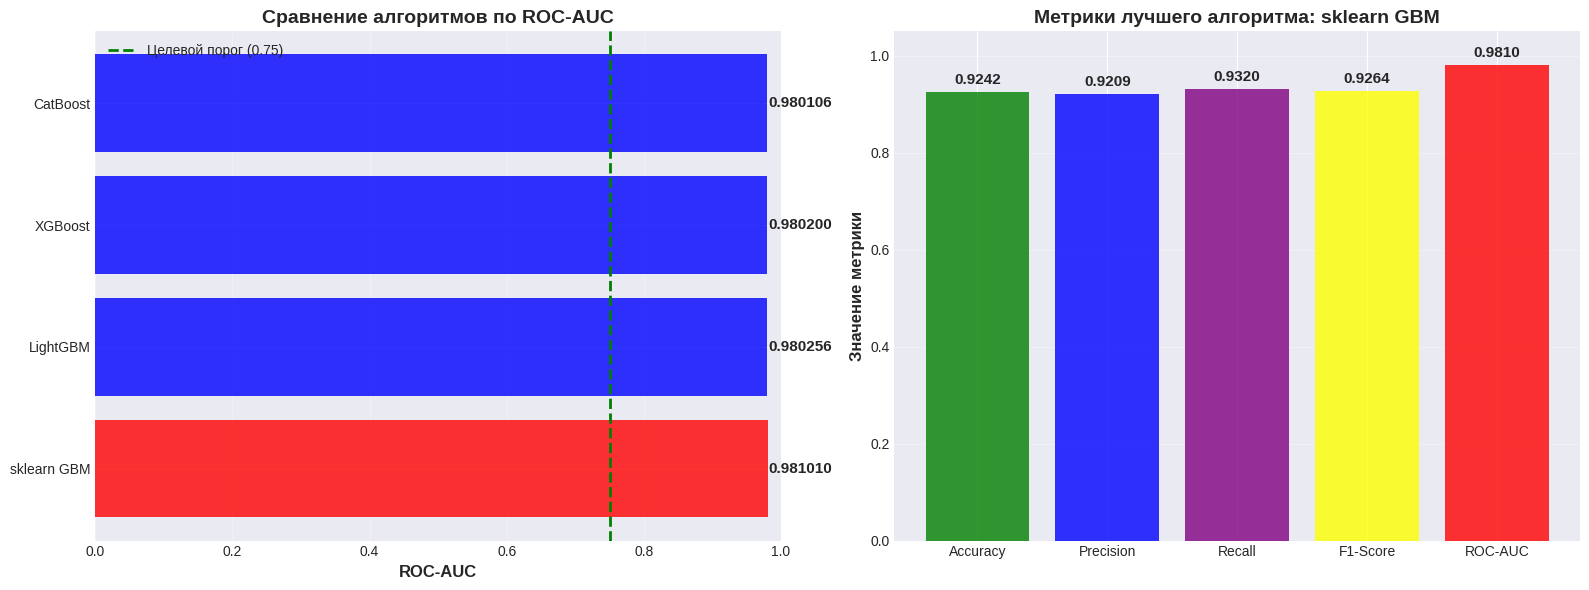

In [88]:
# Визуализация результатов сравнения
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: ROC-AUC всех алгоритмов
ax1 = axes[0]
algorithms = comparison_df['Алгоритм']
roc_aucs = comparison_df['ROC-AUC']

colors = ['red' if alg == best_algorithm else 'blue' for alg in algorithms]
bars = ax1.barh(algorithms, roc_aucs, color=colors, alpha=0.8)

for i, (bar, val) in enumerate(zip(bars, roc_aucs)):
    ax1.text(val + 0.001, i, f'{val:.6f}', va='center', fontsize=11, fontweight='bold')

ax1.axvline(x=0.75, color='green', linestyle='--', linewidth=2, label='Целевой порог (0.75)')
ax1.set_xlabel('ROC-AUC', fontsize=12, fontweight='bold')
ax1.set_title('Сравнение алгоритмов по ROC-AUC', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 1.0)
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# График 2: Все метрики лучшего алгоритма
ax2 = axes[1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [comparison_df.loc[best_idx, m] for m in metrics]

colors_bar = ['green', 'blue', 'purple', 'yellow', 'red']
bars2 = ax2.bar(metrics, values, color=colors_bar, alpha=0.8)

for bar, val in zip(bars2, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('Значение метрики', fontsize=12, fontweight='bold')
ax2.set_title(f'Метрики лучшего алгоритма: {best_algorithm}', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.05)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [89]:
import optuna
from optuna.samplers import TPESampler

# Отключаем логи Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """
    Целевая функция для Optuna.
    Оптимизируем гиперпараметры GradientBoostingClassifier по ROC-AUC.
    """
    # Подбираемые гиперпараметры
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }
    
    # Обучаем модель
    model = GradientBoostingClassifier(**params)
    model.fit(X_train_scaled.values, y_train.values)
    
    # Предсказания на валидации
    y_val_proba = model.predict_proba(X_val_scaled.values)[:, 1]
    
    # Метрика для оптимизации
    roc_auc = roc_auc_score(y_val.values, y_val_proba)
    
    return roc_auc

print("оптимизации гиперпараметров с Optuna")
print()

# Создаем study для максимизации ROC-AUC
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

# Запускаем оптимизацию
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"Лучший ROC-AUC: {study.best_value}")
print()
print(f"Лучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

оптимизации гиперпараметров с Optuna



  0%|          | 0/50 [00:00<?, ?it/s]

Лучший ROC-AUC: 0.983544830947393

Лучшие гиперпараметры:
   n_estimators: 292
   learning_rate: 0.1119176740776068
   max_depth: 10
   min_samples_split: 20
   min_samples_leaf: 6
   subsample: 0.8636956025530133
   max_features: sqrt


In [91]:
# Обучаем финальную модель с оптимальными гиперпараметрами
best_model = GradientBoostingClassifier(**study.best_params)
best_model.fit(X_train_scaled.values, y_train.values)

# Предсказания на валидации
y_val_pred_best = best_model.predict(X_val_scaled.values)
y_val_proba_best = best_model.predict_proba(X_val_scaled.values)[:, 1]

# Метрики
acc_best = accuracy(y_val.values, y_val_pred_best)
prec_best = precision(y_val.values, y_val_pred_best)
rec_best = recall(y_val.values, y_val_pred_best)
f1_best = f1_score(y_val.values, y_val_pred_best)
roc_auc_best = roc_auc_score(y_val.values, y_val_proba_best)

print("Сравнение: До и После оптимизации Optuna")
print()

comparison_optuna = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'До оптимизации': [acc_sklearn_gb, prec_sklearn_gb, rec_sklearn_gb, f1_sklearn_gb, roc_auc_sklearn_gb],
    'После оптимизации': [acc_best, prec_best, rec_best, f1_best, roc_auc_best],
    'Улучшение': [
        acc_best - acc_sklearn_gb,
        prec_best - prec_sklearn_gb,
        rec_best - rec_sklearn_gb,
        f1_best - f1_sklearn_gb,
        roc_auc_best - roc_auc_sklearn_gb
    ]
})

print(comparison_optuna.to_string(index=False))
print()

if roc_auc_best > roc_auc_sklearn_gb:
    print(f"Optuna улучшила ROC-AUC на {(roc_auc_best - roc_auc_sklearn_gb):.6f}!")
else:
    print(f"Базовые параметры были уже хороши (разница: {(roc_auc_best - roc_auc_sklearn_gb):.6f})")

Сравнение: До и После оптимизации Optuna

  Метрика  До оптимизации  После оптимизации  Улучшение
 Accuracy        0.924214           0.926120   0.001907
Precision        0.920883           0.923502   0.002619
   Recall        0.932030           0.932961   0.000931
 F1-Score        0.926423           0.928208   0.001785
  ROC-AUC        0.981010           0.982985   0.001975

Optuna улучшила ROC-AUC на 0.001975!


In [92]:
# Создание submission файла

# Предсказания на тестовых данных (вероятности класса 1)
test_predictions = best_model.predict_proba(X_test_scaled.values)[:, 1]

# Создаем DataFrame с результатами
submission = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': test_predictions
})

# Сохраняем в файл
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)

print(f"Информация о submission:")
print(f"    Количество строк: {len(submission)}")
print(f"    Столбцы: {list(submission.columns)}")
print()
print(f"    Примеры предсказаний:")
print(submission.head(10).to_string(index=False))
print()

print(f"Статистика предсказаний:")
print(f"    Мин: {test_predictions.min():.6f}")
print(f"    Макс: {test_predictions.max():.6f}")
print(f"    Среднее: {test_predictions.mean():.6f}")
print(f"    Медиана: {np.median(test_predictions):.6f}")

# Бинарные предсказания (порог 0.5)
binary_predictions = (test_predictions >= 0.5).astype(int)
print(f"\n   Одобрено (≥0.5):  {binary_predictions.sum()} ({100*binary_predictions.mean():.2f}%)")
print(f"   Отклонено (<0.5): {(1-binary_predictions).sum()} ({100*(1-binary_predictions.mean()):.2f}%)")

print(f"Валидация ROC-AUC: {roc_auc_best:.6f}")

Информация о submission:
    Количество строк: 5000
    Столбцы: ['ID', 'LoanApproved']

    Примеры предсказаний:
 ID  LoanApproved
  0      0.999999
  1      0.000008
  2      0.999998
  3      0.999999
  4      0.999999
  5      0.000009
  6      1.000000
  7      0.999977
  8      0.981783
  9      0.000001

Статистика предсказаний:
    Мин: 0.000000
    Макс: 1.000000
    Среднее: 0.520293
    Медиана: 0.810938

   Одобрено (≥0.5):  2595 (51.90%)
   Отклонено (<0.5): 2405 (48.10%)
Валидация ROC-AUC: 0.982985
